# Восстановление золота из руды

**Об компании:** Компания ООО «Цифры» разрабатывает решения для эффективной работы промышленных предприятий.

**Цель:** Требуется подготовить прототип модели машинного обучения для «Цифры». Модель должна предсказать коэффициент восстановления золота из золотосодержащей руды, тем самым она поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.

**Задачи проекта:**

1. Подготовка данных;
2. Проведение исследовательского анализа данных;
3. Построение и обучение модели.

Для выполнения проекта, мы будем обращайться к библиотекам *pandas*, *matplotlib* и *sklearn.* - их документация нам поможет. Будут использоваться данные с параметрами добычи и очистки. 

# Описание данных

**Данные находятся в трёх файлах:**

    gold_recovery_train_new.csv — обучающая выборка;
    gold_recovery_test_new.csv — тестовая выборка;
    gold_recovery_full_new.csv — исходные данные.

**Технологический процесс**

    Rougher feed — исходное сырье
    Rougher additions (или reagent additions) — флотационные реагенты: Xanthate, Sulphate, Depressant
    Xanthate — ксантогенат (промотер, или активатор флотации);
    Sulphate — сульфат (на данном производстве сульфид натрия);
    Depressant — депрессант (силикат натрия).
    Rougher process (англ. «грубый процесс») — флотация
    Rougher tails — отвальные хвосты
    Float banks — флотационная установка
    Cleaner process — очистка
    Bougher Au — черновой концентрат золота
    Final Au — финальный концентрат золота
    
**Параметры этапов**

    air amount — объём воздуха
    fluid levels — уровень жидкости
    feed size — размер гранул сырья
    feed rate — скорость подачи
    

# Описание проекта

1. Данные индексируются датой и временем получения информации (признак date).

2. Соседние по времени параметры часто похожи.

3. Некоторые параметры недоступны, потому что замеряются и/или рассчитываются значительно позже. Из-за этого в тестовой выборке отсутствуют некоторые признаки, которые могут быть в обучающей.Также в тестовом наборе нет целевых признаков.

4. Исходный датасет содержит обучающую и тестовую выборки со всеми признаками.

5. В нашем распоряжении сырые данные: их просто выгрузили из хранилища. Прежде чем приступить к построению модели, следует проверить их на корректность. Для этого воспользуемся нашей инструкцией


## Подготовка данных

### Откроем датасеты и изучим их.

In [1]:
# импортируем нужные библиотеки
import pandas as pd
import numpy as np
import matplotlib 
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as st
from scipy.stats import ks_2samp
from sklearn.impute import KNNImputer
from catboost import CatBoostRegressor
from sklearn.dummy import DummyRegressor
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler 
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor

In [2]:
# прочитаем датасеты через блок try-except
try:
    df_1 = pd.read_csv("/datasets/gold_recovery_train_new.csv")
    df_2 = pd.read_csv("/datasets/gold_recovery_test_new.csv")
    df_3 = pd.read_csv("/datasets/gold_recovery_full_new.csv")
except:
    print("Проверьте корретность пути к файлу(-ам) или наличие самого(-их) файла(-ов)")

In [3]:
# выведем на экран размерность датасетов с помощью shape
# (строки, столбцы)
print("Размер обущающего:", df_1.shape, 
      "Размер тестового:", df_2.shape, 
      "Размер исходного:", df_3.shape, sep='\n')

Размер обущающего:
(14149, 87)
Размер тестового:
(5290, 53)
Размер исходного:
(19439, 87)


**Для первого датасета (тренировочного):**

In [4]:
# выведем первые 5 строк через head
pd.set_option('display.max_columns', 87) # параметр для задавания кол-ва отображения столбцов 
df_1.head()

date  final.output.concentrate_ag  \
0  2016-01-15 00:00:00                     6.055403   
1  2016-01-15 01:00:00                     6.029369   
2  2016-01-15 02:00:00                     6.055926   
3  2016-01-15 03:00:00                     6.047977   
4  2016-01-15 04:00:00                     6.148599   

   final.output.concentrate_pb  final.output.concentrate_sol  \
0                     9.889648                      5.507324   
1                     9.968944                      5.257781   
2                    10.213995                      5.383759   
3                     9.977019                      4.858634   
4                    10.142511                      4.939416   

   final.output.concentrate_au  final.output.recovery  final.output.tail_ag  \
0                    42.192020              70.541216             10.411962   
1                    42.701629              69.266198             10.462676   
2                    42.657501              68.116445             10.507046   
3                    42.689819              68.347543             10.422762   
4                    42.774141              66.927016             10.360302   

   final.output.tail_pb  final.output.tail_sol  final.output.tail_au  \
0              0.895447              16.904297              2.143149   
1              0.927452              16.634514              2.224930   
2              0.953716              16.208849              2.257889   
3              0.883763              16.532835              2.146849   
4              0.792826              16.525686              2.055292   

   primary_cleaner.input.sulfate  primary_cleaner.input.depressant  \
0                     127.092003                         10.128295   
1                     125.629232                         10.296251   
2                     123.819808                         11.316280   
3                     122.270188                         11.322140   
4                     117.988169                         11.913613   

   primary_cleaner.input.feed_size  primary_cleaner.input.xanthate  \
0                             7.25                        0.988759   
1                             7.25                        1.002663   
2                             7.25                        0.991265   
3                             7.25                        0.996739   
4                             7.25                        1.009869   

   primary_cleaner.output.concentrate_ag  \
0                               8.547551   
1                               8.558743   
2                               8.603505   
3                               7.221879   
4                               9.089428   

   primary_cleaner.output.concentrate_pb  \
0                              10.389648   
1                              10.497069   
2                              10.354494   
3                               8.496563   
4                               9.986786   

   primary_cleaner.output.concentrate_sol  \
0                               19.529297   
1                               19.369147   
2                               19.167579   
3                               15.978538   
4                               19.199864   

   primary_cleaner.output.concentrate_au  primary_cleaner.output.tail_ag  \
0                              34.174427                       14.936526   
1                              34.118526                       16.250511   
2                              33.969464                       16.491823   
3                              28.260743                       16.024359   
4                              33.044932                       16.480185   

   primary_cleaner.output.tail_pb  primary_cleaner.output.tail_sol  \
0                        2.534912                         7.476074   
1                        3.049646                         6.733907   
2                        3.124664                         6.471768   
3             

In [5]:
# 14149 - максильное значение строк (без пропусков объектов)
# выведем информацию об каждом столбце: его типе данных и количестве ненулевых значений
df_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14149 entries, 0 to 14148
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                14149 non-null  object 
 1   final.output.concentrate_ag                         14148 non-null  float64
 2   final.output.concentrate_pb                         14148 non-null  float64
 3   final.output.concentrate_sol                        13938 non-null  float64
 4   final.output.concentrate_au                         14149 non-null  float64
 5   final.output.recovery                               14149 non-null  float64
 6   final.output.tail_ag                                14149 non-null  float64
 7   final.output.tail_pb                                14049 non-null  float64
 8   final.output.tail_sol                               14144 non-null  float64


In [6]:
for x in df_1.columns:
    print("Кол-во пропусков для столбца", x, "равняется", df_1[x].isna().sum())

Кол-во пропусков для столбца date равняется 0
Кол-во пропусков для столбца final.output.concentrate_ag равняется 1
Кол-во пропусков для столбца final.output.concentrate_pb равняется 1
Кол-во пропусков для столбца final.output.concentrate_sol равняется 211
Кол-во пропусков для столбца final.output.concentrate_au равняется 0
Кол-во пропусков для столбца final.output.recovery равняется 0
Кол-во пропусков для столбца final.output.tail_ag равняется 0
Кол-во пропусков для столбца final.output.tail_pb равняется 100
Кол-во пропусков для столбца final.output.tail_sol равняется 5
Кол-во пропусков для столбца final.output.tail_au равняется 0
Кол-во пропусков для столбца primary_cleaner.input.sulfate равняется 20
Кол-во пропусков для столбца primary_cleaner.input.depressant равняется 32
Кол-во пропусков для столбца primary_cleaner.input.feed_size равняется 0
Кол-во пропусков для столбца primary_cleaner.input.xanthate равняется 100
Кол-во пропусков для столбца primary_cleaner.output.concentrate_ag 

In [7]:
df_1_descr = df_1.drop('date', axis=1)
df_1_descr.describe(include='all')

final.output.concentrate_ag  final.output.concentrate_pb  \
count                 14148.000000                 14148.000000   
mean                      5.142034                    10.132960   
std                       1.369586                     1.654930   
min                       0.000000                     0.000000   
25%                       4.211620                     9.297355   
50%                       4.994652                    10.297144   
75%                       5.859540                    11.170603   
max                      16.001945                    17.031899   

       final.output.concentrate_sol  final.output.concentrate_au  \
count                  13938.000000                 14149.000000   
mean                       9.202849                    44.003792   
std                        2.790516                     4.905261   
min                        0.000000                     0.000000   
25%                        7.484645                    43.276111   
50%                        8.845462                    44.872436   
75%                       10.487508                    46.166425   
max                       18.124851                    52.756638   

       final.output.recovery  final.output.tail_ag  final.output.tail_pb  \
count           14149.000000          14149.000000          14049.000000   
mean               66.518832              9.607035              2.597298   
std                10.295402              2.319069              0.971843   
min                 0.000000              0.000000              0.000000   
25%                62.545817              7.997429              1.905973   
50%                67.432775              9.480270              2.592022   
75%                72.346428             11.003707              3.241723   
max               100.000000             19.552149              5.639565   

       final.output.tail_sol  final.output.tail_au  \
count           14144.000000          14149.000000   
mean               10.512122              2.918421   
std                 3.003617              0.903712   
min                 0.000000              0.000000   
25%                 8.811324              2.368607   
50%                10.514621              2.851025   
75%                11.933009              3.434764   
max                22.317730              8.197408   

       primary_cleaner.input.sulfate  primary_cleaner.input.depressant  \
count                   14129.000000                      14117.000000   
mean                      133.320659                          8.866996   
std                        39.431659                          3.361589   
min                         0.003112                          0.000000   
25%                       107.006651                          6.040604   
50%                       133.018328                          8.035811   
75%                       159.825396                         11.522173   
max                       250.127834                         20.052255   

       primary_cleaner.input.feed_size  primary_cleaner.input.xanthate  \
count                     14149.000000                    14049.000000   
mean                          7.322310                        0.885588   
std                           0.614062                        0.372714   
min                           1.080000                        0.000005   
25%                           6.960000                        0.607021   
50%                           7.290000                        0.888749   
75%                           7.700000                        1.100933   
max                          10.470000                        2.512968   

       primary_cleaner.output.concentrate_ag  \
count                           14149.000000   
mean                                8.200916   
std                                 2.005185   
min                                 0.000000   
25%                                 7.107126

**Для второго датасета (тестового):**

In [8]:
pd.set_option('display.max_columns', 87) # параметр для задавания кол-ва отображения столбцов 
df_2.head()

date  primary_cleaner.input.sulfate  \
0  2016-09-01 00:59:59                     210.800909   
1  2016-09-01 01:59:59                     215.392455   
2  2016-09-01 02:59:59                     215.259946   
3  2016-09-01 03:59:59                     215.336236   
4  2016-09-01 04:59:59                     199.099327   

   primary_cleaner.input.depressant  primary_cleaner.input.feed_size  \
0                         14.993118                         8.080000   
1                         14.987471                         8.080000   
2                         12.884934                         7.786667   
3                         12.006805                         7.640000   
4                         10.682530                         7.530000   

   primary_cleaner.input.xanthate  primary_cleaner.state.floatbank8_a_air  \
0                        1.005021                             1398.981301   
1                        0.990469                             1398.777912   
2                        0.996043                             1398.493666   
3                        0.863514                             1399.618111   
4                        0.805575                             1401.268123   

   primary_cleaner.state.floatbank8_a_level  \
0                               -500.225577   
1                               -500.057435   
2                               -500.868360   
3                               -498.863574   
4                               -500.808305   

   primary_cleaner.state.floatbank8_b_air  \
0                             1399.144926   
1                             1398.055362   
2                             1398.860436   
3                             1397.440120   
4                             1398.128818   

   primary_cleaner.state.floatbank8_b_level  \
0                               -499.919735   
1                               -499.778182   
2                               -499.764529   
3                               -499.211024   
4                               -499.504543   

   primary_cleaner.state.floatbank8_c_air  \
0                             1400.102998   
1                             1396.151033   
2                             1398.075709   
3                             1400.129303   
4                             1402.172226   

   primary_cleaner.state.floatbank8_c_level  \
0                               -500.704369   
1                               -499.240168   
2                               -502.151509   
3                               -498.355873   
4                               -500.810606   

   primary_cleaner.state.floatbank8_d_air  \
0                             1399.001695   
1                             1399.508091   
2                             1399.497088   
3                             1401.065165   
4                             1399.480508   

   primary_cleaner.state.floatbank8_d_level  rougher.input.feed_ag  \
0                               -499.485144              13.128569   
1                               -500.416324              13.036280   
2                               -499.715479              13.138412   
3                               -501.038738              12.400507   
4                               -499.374053              11.327427   

   rougher.input.feed_pb  rougher.input.feed_rate  rougher.input.feed_size  \
0               5.636710               489.793655                62.710452   
1               5.526065               490.104534                61.961163   
2               5.426561               489.617969                66.903807   
3               5.114758               476.618130                59.865919   
4               4.767383               488.248117                63.315324   

   rougher.input.feed_sol  rougher.input.feed_au  \
0               42.022440              12.084103   
1               41.187903              11.918977   
2               42.546294              12.091332   
3               41.

In [9]:
df_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5290 entries, 0 to 5289
Data columns (total 53 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   date                                        5290 non-null   object 
 1   primary_cleaner.input.sulfate               5286 non-null   float64
 2   primary_cleaner.input.depressant            5285 non-null   float64
 3   primary_cleaner.input.feed_size             5290 non-null   float64
 4   primary_cleaner.input.xanthate              5286 non-null   float64
 5   primary_cleaner.state.floatbank8_a_air      5290 non-null   float64
 6   primary_cleaner.state.floatbank8_a_level    5290 non-null   float64
 7   primary_cleaner.state.floatbank8_b_air      5290 non-null   float64
 8   primary_cleaner.state.floatbank8_b_level    5290 non-null   float64
 9   primary_cleaner.state.floatbank8_c_air      5290 non-null   float64
 10  primary_clea

In [10]:
for x in df_2.columns:
    print("Кол-во пропусков для столбца", x, "равняется", df_2[x].isna().sum())

Кол-во пропусков для столбца date равняется 0
Кол-во пропусков для столбца primary_cleaner.input.sulfate равняется 4
Кол-во пропусков для столбца primary_cleaner.input.depressant равняется 5
Кол-во пропусков для столбца primary_cleaner.input.feed_size равняется 0
Кол-во пропусков для столбца primary_cleaner.input.xanthate равняется 4
Кол-во пропусков для столбца primary_cleaner.state.floatbank8_a_air равняется 0
Кол-во пропусков для столбца primary_cleaner.state.floatbank8_a_level равняется 0
Кол-во пропусков для столбца primary_cleaner.state.floatbank8_b_air равняется 0
Кол-во пропусков для столбца primary_cleaner.state.floatbank8_b_level равняется 0
Кол-во пропусков для столбца primary_cleaner.state.floatbank8_c_air равняется 0
Кол-во пропусков для столбца primary_cleaner.state.floatbank8_c_level равняется 0
Кол-во пропусков для столбца primary_cleaner.state.floatbank8_d_air равняется 0
Кол-во пропусков для столбца primary_cleaner.state.floatbank8_d_level равняется 0
Кол-во пропусков

In [11]:
df_2_descr = df_1.drop('date', axis=1)
df_2_descr.describe(include='all')

final.output.concentrate_ag  final.output.concentrate_pb  \
count                 14148.000000                 14148.000000   
mean                      5.142034                    10.132960   
std                       1.369586                     1.654930   
min                       0.000000                     0.000000   
25%                       4.211620                     9.297355   
50%                       4.994652                    10.297144   
75%                       5.859540                    11.170603   
max                      16.001945                    17.031899   

       final.output.concentrate_sol  final.output.concentrate_au  \
count                  13938.000000                 14149.000000   
mean                       9.202849                    44.003792   
std                        2.790516                     4.905261   
min                        0.000000                     0.000000   
25%                        7.484645                    43.276111   
50%                        8.845462                    44.872436   
75%                       10.487508                    46.166425   
max                       18.124851                    52.756638   

       final.output.recovery  final.output.tail_ag  final.output.tail_pb  \
count           14149.000000          14149.000000          14049.000000   
mean               66.518832              9.607035              2.597298   
std                10.295402              2.319069              0.971843   
min                 0.000000              0.000000              0.000000   
25%                62.545817              7.997429              1.905973   
50%                67.432775              9.480270              2.592022   
75%                72.346428             11.003707              3.241723   
max               100.000000             19.552149              5.639565   

       final.output.tail_sol  final.output.tail_au  \
count           14144.000000          14149.000000   
mean               10.512122              2.918421   
std                 3.003617              0.903712   
min                 0.000000              0.000000   
25%                 8.811324              2.368607   
50%                10.514621              2.851025   
75%                11.933009              3.434764   
max                22.317730              8.197408   

       primary_cleaner.input.sulfate  primary_cleaner.input.depressant  \
count                   14129.000000                      14117.000000   
mean                      133.320659                          8.866996   
std                        39.431659                          3.361589   
min                         0.003112                          0.000000   
25%                       107.006651                          6.040604   
50%                       133.018328                          8.035811   
75%                       159.825396                         11.522173   
max                       250.127834                         20.052255   

       primary_cleaner.input.feed_size  primary_cleaner.input.xanthate  \
count                     14149.000000                    14049.000000   
mean                          7.322310                        0.885588   
std                           0.614062                        0.372714   
min                           1.080000                        0.000005   
25%                           6.960000                        0.607021   
50%                           7.290000                        0.888749   
75%                           7.700000                        1.100933   
max                          10.470000                        2.512968   

       primary_cleaner.output.concentrate_ag  \
count                           14149.000000   
mean                                8.200916   
std                                 2.005185   
min                                 0.000000   
25%                                 7.107126

**ВЫВОДЫ:**

1. Были обнаружены пропуски в датасетах 
2. Был обнаружен некорретный тип данных у столбца (признака) date - его можно было бы преобразовать в качестве индекса данных, или преобразовать его в datetime. Но мы оставим его, и в случае обучения моделей не будем его в ключать в рассматриваемые признаки
3. Все признаки количественные (цифровые), - и потому технику OHE (one-hot-encoding) проводить не придется
4. Было замеченно то, что у разных признаках (столбцах) большие-меньшие значения по сравнению друг с другом - что сведетельствует о том, что при задании их при обучении и целевой признак, они должны будут прежде приведенны к одному масштабу (должны привести нормализацию данных для корретного масштабирования)
5. По правилам правильного оформления, названия столбцов должны быть с нижним и змеинным регистром, - что и было замечено в названиях столбцов, однако их запись идет и через "." - нам следует понимать, что данный формат записи нужен в дальнейшем инженерам, и потому мы не будем его преобразовывать 

### Проверим, что эффективность обогащения рассчитана правильно. Вычислим её на обучающей выборке для признака rougher.output.recovery. Найдем MAE между нашими расчётами и значением признака. Опишем выводы.

**Формула расчета:**

**RECOVERY** = (C * (F - T)) / (F * (c - T)) * 100

где:

**C** — доля золота в концентрате после флотации/очистки;

**F** — доля золота в сырье/концентрате до флотации/очистки;

**T** — доля золота в отвальных хвостах после флотации/очистки.

In [12]:
c_au = df_3['rougher.output.concentrate_au']  # доля золота в концентрате после флотации/очистки;
f_au = df_3['rougher.input.feed_au'] # доля золота в сырье/концентрате до флотации/очистки;
t_au = df_3['rougher.output.tail_au']  # доля золота в отвальных хвостах после флотации/очистки.

RECOVERY = (c_au  * (f_au - t_au)) / (f_au * (c_au - t_au)) * 100

MAE = mean_absolute_error(RECOVERY, df_3['rougher.output.recovery'])
print("MAE =", MAE)

MAE = 9.874045668302637e-15


**ВЫВОД:**

Видим, что значение метрики MAE очень низкое, следовательно, - это говорит о незначительном отклонении и потому расчет в датасетах можно считать корретным (правильным)

###  Проанализируем признаки, недоступные в тестовой выборке. Что это за параметры? К какому типу относятся?

In [13]:
feat = sorted(set(df_1.columns) - set(df_2.columns))
print("Кол-во отсутсвующих признаков:",len(feat))
print("Cписок с отсутсвующими признаками:", feat)

Кол-во отсутсвующих признаков: 34
Cписок с отсутсвующими признаками: ['final.output.concentrate_ag', 'final.output.concentrate_au', 'final.output.concentrate_pb', 'final.output.concentrate_sol', 'final.output.recovery', 'final.output.tail_ag', 'final.output.tail_au', 'final.output.tail_pb', 'final.output.tail_sol', 'primary_cleaner.output.concentrate_ag', 'primary_cleaner.output.concentrate_au', 'primary_cleaner.output.concentrate_pb', 'primary_cleaner.output.concentrate_sol', 'primary_cleaner.output.tail_ag', 'primary_cleaner.output.tail_au', 'primary_cleaner.output.tail_pb', 'primary_cleaner.output.tail_sol', 'rougher.calculation.au_pb_ratio', 'rougher.calculation.floatbank10_sulfate_to_au_feed', 'rougher.calculation.floatbank11_sulfate_to_au_feed', 'rougher.calculation.sulfate_to_au_concentrate', 'rougher.output.concentrate_ag', 'rougher.output.concentrate_au', 'rougher.output.concentrate_pb', 'rougher.output.concentrate_sol', 'rougher.output.recovery', 'rougher.output.tail_ag', 'ro

**ВЫВОД:**

Нет ни одного output и calculation у тренировочного датасета. Первое получается по результату работы режима, а во второй вычисляемые значения после партии. Этих признаков в принципе не может быть у новых данных. Тип данных параметров относится к float64

### Предобработка данных

**Произведем замену пустых значений в столбцах с использованием k-ближайших соседей**

In [14]:
# функция заполнения пропусков с использованием k-ближайших соседей
imputer = KNNImputer() 
df_22 = df_2.drop('date', axis=1)
df_11 = df_1.drop('date', axis=1)
df_33 = df_3.drop('date', axis=1)

#заполним пропуски в тестовой выборке
df_test = pd.DataFrame(imputer.fit_transform(df_22))
 
#заполним пропуски в обучающей выборке
df_train = pd.DataFrame(imputer.fit_transform(df_11))

#заполним пропуски в всей выборке
df_full = pd.DataFrame(imputer.fit_transform(df_33))

In [15]:
# full
full = []
for x in df_33.columns:
    full.append(x)
    
full_1 = []
for x in df_full.columns:
    full_1.append(x)

for x in range(len(df_33.columns)):
    df_full = df_full.rename(columns={full_1[x]: full[x]})
    
# train
train = []
for x in df_11.columns:
    train.append(x)
    
train_1 = []
for x in df_train.columns:
    train_1.append(x)

for x in range(len(df_11.columns)):
    df_train = df_train.rename(columns={train_1[x]: train[x]})
    
# test
test = []
for x in df_22.columns:
    test.append(x)
    
test_1 = []
for x in df_test.columns:
    test_1.append(x)

for x in range(len(df_22.columns)):
    df_test = df_test.rename(columns={test_1[x]: test[x]})

In [16]:
df_full['date'] = df_3['date']
df_train['date'] = df_1['date']
df_test['date'] = df_2['date']

## Анализ данных

### Посмотрим, как меняется концентрация металлов (Au, Ag, Pb) на различных этапах очистки. Опишем выводы.

**Для Золота (Au):**

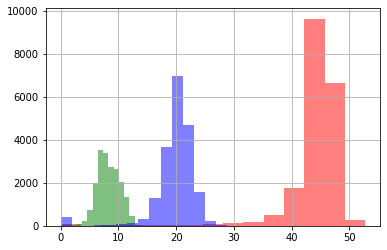

In [17]:
df_full['final.output.concentrate_au'].hist(bins=15, alpha=0.5, color='r')
df_full['rougher.input.feed_au'].hist(bins=15, alpha=0.5, color='g')
df_full['rougher.output.concentrate_au'].hist(bins=15, alpha=0.5, color='b')
plt.show()

# print("Красным: на финальной стадии")
# print("Зеленным: в сырье")
# print("Синим: в черновой стадии концетрата")

**Также посмотрим для каждого этапа отдельно с помощью boxplot**

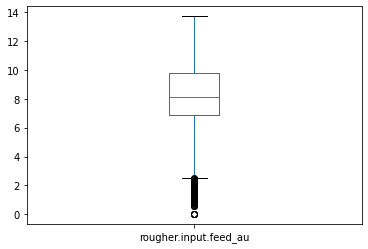

In [18]:
df_full['rougher.input.feed_au'].plot(kind="box")
plt.show()

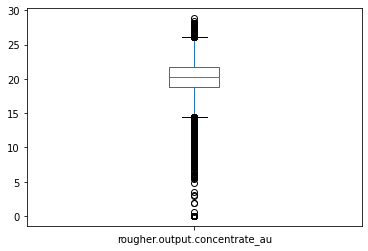

In [19]:
df_full['rougher.output.concentrate_au'].plot(kind="box")
plt.show()

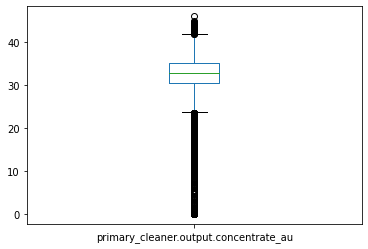

In [20]:
df_full['primary_cleaner.output.concentrate_au'].plot(kind="box")
plt.show()

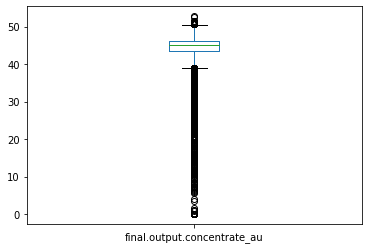

In [21]:
df_full['final.output.concentrate_au'].plot(kind="box")
plt.show()

**Для Серебра (Ag):**

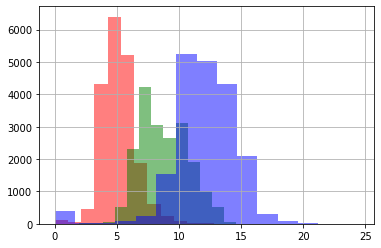

In [22]:
df_full['final.output.concentrate_ag'].hist(bins=15, alpha=0.5, color='r')
df_full['rougher.input.feed_ag'].hist(bins=15, alpha=0.5, color='g')
df_full['rougher.output.concentrate_ag'].hist(bins=15, alpha=0.5, color='b')
plt.show()


# print("Красным: на финальной стадии")
# print("Зеленным: в сырье")
# print("Синим: в черновой стадии концетрата")

**Также посмотрим для каждого этапа отдельно с помощью boxplot**

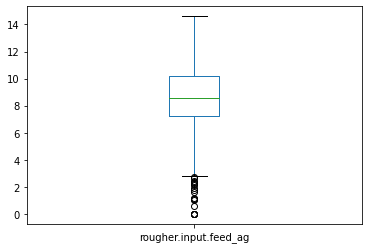

In [23]:
df_full['rougher.input.feed_ag'].plot(kind="box")
plt.show()

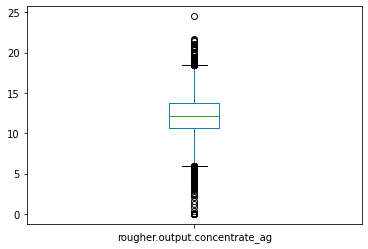

In [24]:
df_full['rougher.output.concentrate_ag'].plot(kind="box")
plt.show()

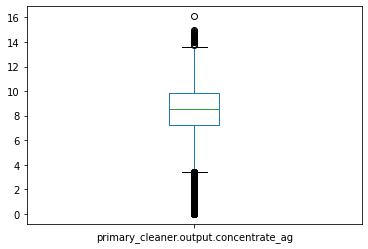

In [25]:
df_full['primary_cleaner.output.concentrate_ag'].plot(kind="box")
plt.show()

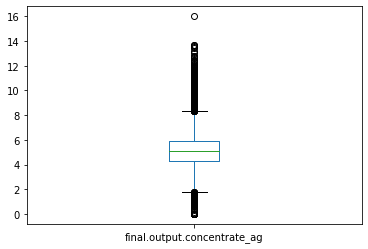

In [26]:
df_full['final.output.concentrate_ag'].plot(kind="box")
plt.show()

**Для Pb:**

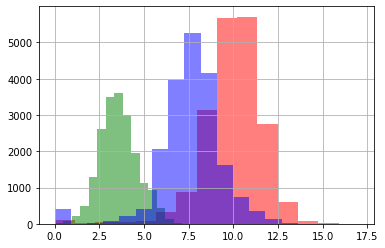

In [27]:
df_full['final.output.concentrate_pb'].hist(bins=15, alpha=0.5, color='r') 
df_full['rougher.input.feed_pb'].hist(bins=15, alpha=0.5, color='g') 
df_full['rougher.output.concentrate_pb'].hist(bins=15, alpha=0.5, color='b')
plt.show()
# print("Красным: на финальной стадии")
# print("Зеленным: в сырье")
# print("Синим: в черновой стадии концетрата")

**Также посмотрим для каждого этапа отдельно с помощью boxplot**

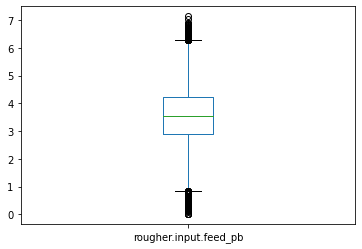

In [28]:
df_full['rougher.input.feed_pb'].plot(kind="box")
plt.show()

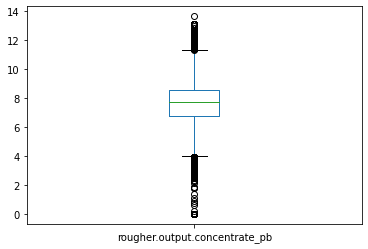

In [29]:
df_full['rougher.output.concentrate_pb'].plot(kind="box")
plt.show()

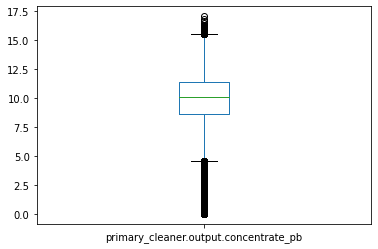

In [30]:
df_full['primary_cleaner.output.concentrate_pb'].plot(kind="box")
plt.show()

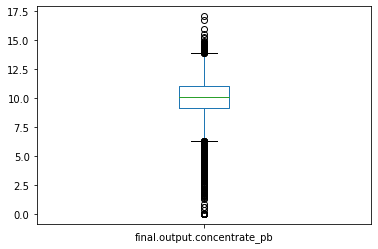

In [31]:
df_full['final.output.concentrate_pb'].plot(kind="box")
plt.show()

**ВЫВОДЫ:**

1. Заметили, что на распределении очень много около-нулевых выбросов

2. Заметили, что для золота Au каждый раз на последующем этапе увеличиваются числовые показатели (как медиана)

3. Заметили, что для серебра Ag медианное значение и числовые характеристики на втором этапа начали увеличиваться, затем на последующих 3 и 4 этапах начали уменьшаться

4. Заметили, что для свинца Pb числовые характеристики и медианна начали увеличиваться до 3 этапа, но после 4 практически остался без изменений

### Сравним распределения размеров гранул сырья на обучающей и тестовой выборках. Если распределения сильно отличаются друг от друга, оценка модели будет неправильной.

1. Для сравнения распределения, будем использовать тест Колмогорова-Смирнова.

2. Посмотрим какое среднее и дисперсия у разных выборках.

3. Визуализируем распределения

**На обучающей и тренировочной по столбцу 'rougher.input.feed_size'**

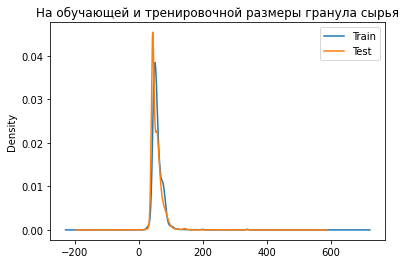

На тренировочной (Train)
Среднее (Mean): 60.11784437670307
Дисперсия (Var): 504.78039244422797
На тестовой (Test)
Среднее (Mean): 55.95537507698537
Дисперсия (Var): 364.0725933136224


In [32]:
df = pd.DataFrame({
    'Train': df_train['rougher.input.feed_size'],
    'Test': df_test['rougher.input.feed_size'],
})
ax = df.plot.kde(title="На обучающей и тренировочной размеры гранула сырья")
plt.show()
print("На тренировочной (Train)")
print("Среднее (Mean):", df_train['rougher.input.feed_size'].mean())
print("Дисперсия (Var):", np.var(df_train['rougher.input.feed_size']))
print("На тестовой (Test)")
print("Среднее (Mean):", df_test['rougher.input.feed_size'].mean())
print("Дисперсия (Var):", np.var(df_test['rougher.input.feed_size']))

**Будем ниже использовать тест Колмогорова-Смирнова:**

In [33]:
print(ks_2samp(df_train['rougher.input.feed_size'], df_test['rougher.input.feed_size']))

KstestResult(statistic=0.2503699821278291, pvalue=3.9279100100206624e-213)


**На обучающей и тренировочной по столбцу 'primary_cleaner.input.feed_size'**

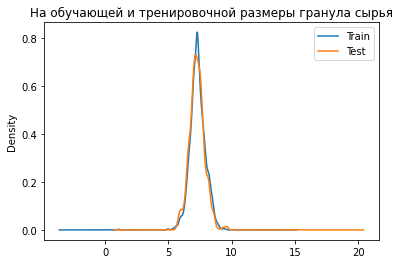

На тренировочной (Train)
Среднее (Mean): 7.322309906901314
Дисперсия (Var): 0.3770458141328873
На тестовой (Test)
Среднее (Mean): 7.266339191270906
Дисперсия (Var): 0.3722965577722183


In [34]:
df = pd.DataFrame({
    'Train': df_train['primary_cleaner.input.feed_size'],
    'Test': df_test['primary_cleaner.input.feed_size'],
})
ax = df.plot.kde(title="На обучающей и тренировочной размеры гранула сырья")
plt.show()
print("На тренировочной (Train)")
print("Среднее (Mean):", df_train['primary_cleaner.input.feed_size'].mean())
print("Дисперсия (Var):", np.var(df_train['primary_cleaner.input.feed_size']))
print("На тестовой (Test)")
print("Среднее (Mean):", df_test['primary_cleaner.input.feed_size'].mean())
print("Дисперсия (Var):", np.var(df_test['primary_cleaner.input.feed_size']))

**Будем ниже использовать тест Колмогорова-Смирнова:**

In [35]:
print(ks_2samp(df_train['primary_cleaner.input.feed_size'], df_test['primary_cleaner.input.feed_size']))

KstestResult(statistic=0.05922065470904381, pvalue=3.5273935105512727e-12)


**ВЫВОДЫ:**

Подтверждаем, что распределения этих данных cхожи по распределению, но не одинаковы - отличны. По графикам мы это подтвердили, а использование статистических гипотез стало хорошим дополняющим потверждением


### Исследуем суммарную концентрацию всех веществ на разных стадиях: в сырье, в черновом и финальном концентратах.

In [36]:
df_rougher_input = df_full['rougher.input.feed_ag'] + \
                   df_full['rougher.input.feed_pb'] + \
                   df_full['rougher.input.feed_au'] 

df_rougher_output = df_full['rougher.output.concentrate_ag'] + \
                    df_full['rougher.output.concentrate_pb'] + \
                    df_full['rougher.output.concentrate_au']

df_final = df_full['final.output.concentrate_ag'] + \
            df_full['final.output.concentrate_pb'] + \
            df_full['final.output.concentrate_au']


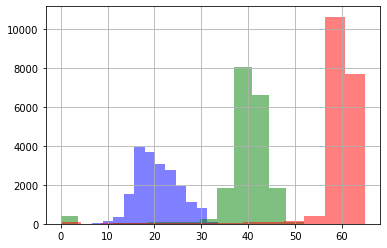

In [37]:
df_rougher_input.hist(bins=15, alpha=0.5, color='b')
df_rougher_output.hist(bins=15, alpha=0.5, color='g')
df_final.hist(bins=15, alpha=0.5, color='r')
plt.show()

# (подписями, заголовком, легендой).
# hist.title("Cуммарная концентрация всех веществ на разных стадиях")
# plt.xlabel("Значения числовые")
# plt.ylabel("Количество значений")

**ВЫВОДЫ:**

1. Заметили, что суммарно для всех этапов с переходом к новому этапу - числовые значанея изменяются.
2. Важное замечание мы отметили в том, что обнаружили выбросы, - что может некоретно в дальнейшем сказать на качестве обучаемости модели, а потому их следут отбросить

### Обработаем выбросы и аномалии 

In [38]:
# TRAIN
# AG # AU PB
df_train = df_train[df_train['rougher.input.feed_ag'] > 0]
df_train = df_train[df_train['rougher.input.feed_au'] > 0]      
df_train = df_train[df_train['rougher.input.feed_pb'] > 0]  

df_train = df_train[df_train['rougher.output.concentrate_ag'] > 0]      
df_train = df_train[df_train['rougher.output.concentrate_pb'] > 0]      
df_train = df_train[df_train['rougher.output.concentrate_au'] > 0] 

df_train = df_train[df_train['final.output.concentrate_ag'] > 0]      
df_train = df_train[df_train['final.output.concentrate_pb'] > 0]      
df_train = df_train[df_train['final.output.concentrate_au'] > 0]  

**ВЫВОДЫ:**

1. Удалаять аномалии нужно только с 0 значениями. Остальные аномалии лучше не трогать, т.к. в реальной (в т.ч. тестовой выборке) подобные аномалии (больше 0 но меньше 4,5) моут встречаться, а удаляя их из тренировочной выборке, мы не оставим шансов обучиться модели работать с такими объектами.
2. В тестовой удалять аномалии не нужно, потому что таким образом мы тестовую подгоняем под работу модели, а тестовая выборка , должны быть максимально приближены  к реальным данным, и в реальности модель будет сталкиваться с разными данными, поэтому в тестовой лучше не удалять аномалии.

## Модель

### Напишем функцию для вычисления итоговой sMAPE.

Наши целевые признаки:

1. Эффективность обогащения чернового концентрата: rougher.output.recovery;

2. Эффективность обогащения финального концентрата: final.output.recovery.

In [39]:
def smape(a, f):
    return 100/len(a) * np.sum(2 * np.abs(f - a) / (np.abs(a) + np.abs(f)))

def final_smape(rougher, final):
    return 0.25 * rougher + 0.75 * final

### Обучим разные модели и оценим их качество кросс-валидацией. Выберем лучшую модель и проверим её на тестовой выборке. Опишем выводы.

Будем придерживаться следующего порядка:

1. Обучаем все модели и rougher , и final .

2. Находим по валидации лучшую модель rougher

3. Находим по валидации лучшую модель final

4. Находим показание метрик sMAPE на тесте на лучших моделях.

5. Оцениваем финальный sMAPE

**Для тестового датасета объединим и подтянем целевые признаки из исходного датасета по общему столбцу (date)**

**Для тренировочного датасета приведем количество признаков к количеству равному тестовому, так как нам необходимо делать предсказания по тестовому, - это требования заказчика**

In [40]:
df_train_new = df_train[df_test.columns]

In [41]:
df_test = df_test.merge(df_full[['date', 'rougher.output.recovery', 'final.output.recovery']], on='date', how='left')

In [42]:
df_train_new = df_train_new.merge(df_full[['date', 'rougher.output.recovery', 'final.output.recovery']], on='date', how='left')

In [43]:
df_train_new = df_train_new.set_index('date')
df_test =  df_test.set_index('date')

In [44]:
print(df_train_new.shape)
print(df_test.shape)

(13795, 54)
(5290, 54)


In [45]:
df_train_new.head()

primary_cleaner.input.sulfate  \
date                                                 
2016-01-15 00:00:00                     127.092003   
2016-01-15 01:00:00                     125.629232   
2016-01-15 02:00:00                     123.819808   
2016-01-15 03:00:00                     122.270188   
2016-01-15 04:00:00                     117.988169   

                     primary_cleaner.input.depressant  \
date                                                    
2016-01-15 00:00:00                         10.128295   
2016-01-15 01:00:00                         10.296251   
2016-01-15 02:00:00                         11.316280   
2016-01-15 03:00:00                         11.322140   
2016-01-15 04:00:00                         11.913613   

                     primary_cleaner.input.feed_size  \
date                                                   
2016-01-15 00:00:00                             7.25   
2016-01-15 01:00:00                             7.25   
2016-01-15 02:00:00                             7.25   
2016-01-15 03:00:00                             7.25   
2016-01-15 04:00:00                             7.25   

                     primary_cleaner.input.xanthate  \
date                                                  
2016-01-15 00:00:00                        0.988759   
2016-01-15 01:00:00                        1.002663   
2016-01-15 02:00:00                        0.991265   
2016-01-15 03:00:00                        0.996739   
2016-01-15 04:00:00                        1.009869   

                     primary_cleaner.state.floatbank8_a_air  \
date                                                          
2016-01-15 00:00:00                             1549.775757   
2016-01-15 01:00:00                             1576.166671   
2016-01-15 02:00:00                             1601.556163   
2016-01-15 03:00:00                             1599.968720   
2016-01-15 04:00:00                             1601.339707   

                     primary_cleaner.state.floatbank8_a_level  \
date                                                            
2016-01-15 00:00:00                               -498.912140   
2016-01-15 01:00:00                               -500.904965   
2016-01-15 02:00:00                               -499.997791   
2016-01-15 03:00:00                               -500.951778   
2016-01-15 04:00:00                               -498.975456   

                     primary_cleaner.state.floatbank8_b_air  \
date                                                          
2016-01-15 00:00:00                             1551.434204   
2016-01-15 01:00:00                             1575.950626   
2016-01-15 02:00:00                             1600.386685   
2016-01-15 03:00:00                             1600.659236   
2016-01-15 04:00:00                             1601.437854   

                     primary_cleaner.state.floatbank8_b_level  \
date                                                            
2016-01-15 00:00:00                               -516.403442   
2016-01-15 01:00:00                               -499.865889   
2016-01-15 02:00:00                               -500.607762   
2016-01-15 03:00:00                               -499.677094   
2016-01-15 04:00:00                               -500.323246   

                     primary_cleaner.state.floatbank8_c_air  \
date                                                          
2016-01-15 00:00:00                             1549.873901   
2016-01-15 01:00:00                             1575.994189   
2016-01-15 02:00:00                             1602.003542   
2016-01-15 03:00:00                             1600.304144   
2016-01-15 04:00:00                             1599.581894   

                     primary_cleaner.state.floatbank8_c_level  \
date                                                            
2016-01-15 00:00:00                               -498.666595   
2016-01-15 01:00:00           

In [46]:
df_test.head()

primary_cleaner.input.sulfate  \
date                                                 
2016-09-01 00:59:59                     210.800909   
2016-09-01 01:59:59                     215.392455   
2016-09-01 02:59:59                     215.259946   
2016-09-01 03:59:59                     215.336236   
2016-09-01 04:59:59                     199.099327   

                     primary_cleaner.input.depressant  \
date                                                    
2016-09-01 00:59:59                         14.993118   
2016-09-01 01:59:59                         14.987471   
2016-09-01 02:59:59                         12.884934   
2016-09-01 03:59:59                         12.006805   
2016-09-01 04:59:59                         10.682530   

                     primary_cleaner.input.feed_size  \
date                                                   
2016-09-01 00:59:59                         8.080000   
2016-09-01 01:59:59                         8.080000   
2016-09-01 02:59:59                         7.786667   
2016-09-01 03:59:59                         7.640000   
2016-09-01 04:59:59                         7.530000   

                     primary_cleaner.input.xanthate  \
date                                                  
2016-09-01 00:59:59                        1.005021   
2016-09-01 01:59:59                        0.990469   
2016-09-01 02:59:59                        0.996043   
2016-09-01 03:59:59                        0.863514   
2016-09-01 04:59:59                        0.805575   

                     primary_cleaner.state.floatbank8_a_air  \
date                                                          
2016-09-01 00:59:59                             1398.981301   
2016-09-01 01:59:59                             1398.777912   
2016-09-01 02:59:59                             1398.493666   
2016-09-01 03:59:59                             1399.618111   
2016-09-01 04:59:59                             1401.268123   

                     primary_cleaner.state.floatbank8_a_level  \
date                                                            
2016-09-01 00:59:59                               -500.225577   
2016-09-01 01:59:59                               -500.057435   
2016-09-01 02:59:59                               -500.868360   
2016-09-01 03:59:59                               -498.863574   
2016-09-01 04:59:59                               -500.808305   

                     primary_cleaner.state.floatbank8_b_air  \
date                                                          
2016-09-01 00:59:59                             1399.144926   
2016-09-01 01:59:59                             1398.055362   
2016-09-01 02:59:59                             1398.860436   
2016-09-01 03:59:59                             1397.440120   
2016-09-01 04:59:59                             1398.128818   

                     primary_cleaner.state.floatbank8_b_level  \
date                                                            
2016-09-01 00:59:59                               -499.919735   
2016-09-01 01:59:59                               -499.778182   
2016-09-01 02:59:59                               -499.764529   
2016-09-01 03:59:59                               -499.211024   
2016-09-01 04:59:59                               -499.504543   

                     primary_cleaner.state.floatbank8_c_air  \
date                                                          
2016-09-01 00:59:59                             1400.102998   
2016-09-01 01:59:59                             1396.151033   
2016-09-01 02:59:59                             1398.075709   
2016-09-01 03:59:59                             1400.129303   
2016-09-01 04:59:59                             1402.172226   

                     primary_cleaner.state.floatbank8_c_level  \
date                                                            
2016-09-01 00:59:59                               -500.704369   
2016-09-01 01:59:59           

**Задаем признаки и таргеты на обоих выборках**

In [47]:
# для датасета: df_train_new
# Признаки 
features_train = df_train_new.drop(['final.output.recovery','rougher.output.recovery'],axis=1) # 'date',
# Целевые переменные 
target_train_rough = df_train_new['rougher.output.recovery'] #.loc[features_train.index]
target_train_final = df_train_new['final.output.recovery'] #.loc[features_train.index]

# для датасета: df_test
# Признаки
features_test = df_test.drop(['final.output.recovery','rougher.output.recovery'], axis=1) #'date',
# Целевые переменные 
target_test_rough = df_test['rougher.output.recovery'] #.loc[features_test.index]
target_test_final = df_test['final.output.recovery'] #.loc[features_test.index]

**Проверим корретность наших датасетов**

In [48]:
print("Размер тренировочного датасета:", features_train.shape)
print("Размер тестового датасета:",features_test.shape)

Размер тренировочного датасета: (13795, 52)
Размер тестового датасета: (5290, 52)


**Создадим для cross_val_score нашу метрику**

In [49]:
custom_score = make_scorer(smape, greater_is_better=False) 

**Будем вводить baseline модель**

In [50]:
final_baseline = DummyRegressor(strategy='mean').fit(features_train, target_train_final)
final_baseline_predicted = final_baseline.predict(target_test_final)
dummy_test_rough_smape = smape(target_test_final, final_baseline_predicted)

rough_baseline = DummyRegressor(strategy='mean').fit(features_train, target_train_rough)
rough_baseline_predicted = rough_baseline.predict(target_test_rough)
dummy_test_final_smape = smape(target_test_rough, rough_baseline_predicted)

rec = final_smape(dummy_test_rough_smape, dummy_test_final_smape)
print("FINAL SMAPE", rec)

print("ROUGH", dummy_test_rough_smape)
print("FINAL", dummy_test_final_smape)

FINAL SMAPE 9.318684888896271
ROUGH 10.074847136380473
FINAL 9.066630806401538


In [52]:
v1 = cross_val_score(final_baseline, features_train, target_train_final, cv=5, scoring=custom_score)
print("Для final:", v1)

v2 = cross_val_score(rough_baseline, features_train, target_train_rough, cv=5, scoring=custom_score)
print("Для rough:", v2)

for x in range(len(v1)):
    print(f"(final smape {x})", final_smape(v1[x], v2[x]))

Для final: [-10.61071393  -9.15538849  -9.581468   -11.49859714 -11.39210667]
Для rough: [-10.12309009  -7.65488024  -5.0147073   -7.31752228  -8.91289209]
(final smape 0) -10.244996048283564
(final smape 1) -8.030007300140666
(final smape 2) -6.156397472884192
(final smape 3) -8.362790996897411
(final smape 4) -9.532695739702834


**Будем проводить стандартизацию отдельно для каждого сплита кросс-валидации:**

In [54]:
ml_model = LinearRegression() 
pipeline = make_pipeline(StandardScaler(), ml_model)
print("для Final", cross_val_score(pipeline, features_train, target_train_final, cv=5, scoring=custom_score))

ml_model_2 = LinearRegression() 
pipeline_2 = make_pipeline(StandardScaler(), ml_model_2)
print("для Rough", cross_val_score(pipeline_2, features_train, target_train_rough,  cv=5, scoring=custom_score))

v_f = cross_val_score(pipeline, features_train, target_train_final, cv=5, scoring=custom_score)
v_r = cross_val_score(pipeline_2, features_train, target_train_rough,  cv=5, scoring=custom_score)

# for x in range(len(v_f)):
    # print(f"(final smape {x})", final_smape(v_f[x], v_r[x]))
v_f = sum(v_f)
v_r = sum(v_r)

для Final [-13.21601165  -9.78161837  -9.54640396  -9.25617048 -14.0440488 ]
для Rough [-9.46386942 -7.00499748 -5.60311427 -4.84621042 -9.05522112]


In [55]:
print("Rough", v_r / 5 *-1) # усредним наши оценки 
print("Final", v_f / 5 *-1) # усредним наши оценки 

Rough 7.194682542282356
Final 11.168850651926185


**Линейная регрессия**

In [56]:
# ROUGH
# Инициализируем модель  _rough
model_lin_regr_rough = LinearRegression() 
# Обучим модель 
model_lin_regr_rough.fit(features_train, target_train_rough)
# Получим предсказания на трейни
test_pred_lin_regr_rough = model_lin_regr_rough.predict(features_test)

# FINAL
# Инициализируем модель  _final
model_lin_regr_final = LinearRegression() 
# Обучим модель 
model_lin_regr_final.fit(features_train, target_train_final)
# Получим предсказания на трейни
test_pred_lin_regr_final = model_lin_regr_final.predict(features_test)
 
# sMAPE, применим ранее созданную функцию smape
sMAPE_rough_lin_regr = smape(target_test_rough, test_pred_lin_regr_rough) 
sMAPE_final_lin_regr = smape(target_test_final, test_pred_lin_regr_final) 
# Финальная sMAPE, применим ранее созданную функцию final_smape
# sMAPE = final_smape(sMAPE_rough, sMAPE_final)
 
print("sMAPE_rough_lin_regr", sMAPE_rough_lin_regr)
print("sMAPE_final_lin_regr", sMAPE_final_lin_regr)
# print("Финальная sMAPE для Линейоной регресии: ", sMAPE)

sMAPE_rough_lin_regr 8.461813461703766
sMAPE_final_lin_regr 9.977064728390125


**Подберем для Решающего дерева регресора оптимальные гиперпараметры через GridSearchCV (ROUGH)**

In [57]:
%%time  

model_gs_rough = DecisionTreeRegressor(random_state=42)

parametrs  = {'max_depth' : [2, 3, 4, 5, 6, 7, 8],
              'min_samples_split' : [2, 3, 4, 5, 6, 7, 8],
             
}

gs = GridSearchCV(estimator=model_gs_rough, param_grid = parametrs, cv=5, scoring=custom_score)
search_model = gs.fit(features_train, target_train_rough)

# CPU times: user 1min 8s, sys: 182 ms, total: 1min 6s
# Wall time: 1min 8s

CPU times: user 1min 11s, sys: 295 ms, total: 1min 11s
Wall time: 1min 11s


In [58]:
print("GridSearchCV (ROUGH)")
print(f"Получили лучшие гиперпараметры: {search_model.best_params_} - их и будем использовать как лучшие") 
print("best_estimator_:", search_model.best_estimator_)
print("best_score_", search_model.best_score_ * -1)

GridSearchCV (ROUGH)
Получили лучшие гиперпараметры: {'max_depth': 3, 'min_samples_split': 2} - их и будем использовать как лучшие
best_estimator_: DecisionTreeRegressor(max_depth=3, random_state=42)
best_score_ 7.031213457061912


**Подберем для Решающего дерева регресора оптимальные гиперпараметры через GridSearchCV (FINAL)**

In [59]:
%%time  

model_gs_final = DecisionTreeRegressor(random_state=42)

parametrs  = {'max_depth' : [2, 3, 4, 5, 6, 7, 8],
              'min_samples_split' : [2, 3, 4, 5, 6, 7, 8]
             
}

gs = GridSearchCV(estimator=model_gs_final, param_grid = parametrs, cv=5, scoring=custom_score)

search_model = gs.fit(features_train, target_train_final)


# CPU times: user 1min 6s, sys: 185 ms, total: 1min 7s
# Wall time: 1min 7s

CPU times: user 1min 12s, sys: 312 ms, total: 1min 12s
Wall time: 1min 12s


In [60]:
print("GridSearchCV (FINAL)")
print(f"Получили лучшие гиперпараметры: {search_model.best_params_} - их и будем использовать как лучшие") 
print("best_estimator_:", search_model.best_estimator_)
print("best_score_", search_model.best_score_ * -1)

GridSearchCV (FINAL)
Получили лучшие гиперпараметры: {'max_depth': 2, 'min_samples_split': 2} - их и будем использовать как лучшие
best_estimator_: DecisionTreeRegressor(max_depth=2, random_state=42)
best_score_ 9.38560800397947


**Решающее дерево регрессор**

In [61]:
# ROUGH
# Инициализируем модель  _rough
model_rough = DecisionTreeRegressor(random_state=42, max_depth = 3, min_samples_split = 2)
# Обучим модель 
model_rough.fit(features_train, target_train_rough)
# Получим предсказания на тесте
test_pred_rough = model_rough.predict(features_test)

# FINAL
# Инициализируем модель  _final
model_final = DecisionTreeRegressor(random_state=42, max_depth = 2, min_samples_split = 2)
# Обучим модель 
model_final.fit(features_train, target_train_final)
# Получим предсказания на тесте
test_pred_final = model_final.predict(features_test)
 
# sMAPE, применим ранее созданную функцию smape
sMAPE_rough_decision = smape(target_test_rough, test_pred_rough)
sMAPE_final_decision = smape(target_test_final, test_pred_final)

# Финальная sMAPE, применим ранее созданную функцию final_smape
# sMAPE = final_smape(sMAPE_rough, sMAPE_final)
 
print("sMAPE_rough_decision", sMAPE_rough_decision)
print("sMAPE_final_decision", sMAPE_final_decision)
# print("Финальная sMAPE для Решающего леса регрессора: ", sMAPE)

sMAPE_rough_decision 8.93212085462186
sMAPE_final_decision 9.923403133068438


**Подберем для CatBoostRegressor оптимальные гиперпараметры через GridSearchCV (ROUGH)** 

In [62]:
%%time  

model_gs_rough = CatBoostRegressor(random_state=42)

parametrs  = {'n_estimators' : [100, 125, 150, 175, 200, 225, 250],
              'max_depth' : [2, 3, 4, 5, 6, 7, 8]
             
}

gs = GridSearchCV(estimator=model_gs_rough, param_grid = parametrs, cv=5, scoring=custom_score)

search_model = gs.fit(features_train, target_train_rough)

# CPU times: user user 12min 44s , sys: 3.7 s, total: 4min 26s
# Wall time: 14min 44s

Learning rate set to 0.388995
0:	learn: 6.5512599	total: 53.9ms	remaining: 5.33s
1:	learn: 6.0451583	total: 59.2ms	remaining: 2.9s
2:	learn: 5.7395186	total: 63ms	remaining: 2.04s
3:	learn: 5.4767147	total: 66.7ms	remaining: 1.6s
4:	learn: 5.3144506	total: 70.6ms	remaining: 1.34s
5:	learn: 5.2111954	total: 75.5ms	remaining: 1.18s
6:	learn: 5.1368680	total: 80.7ms	remaining: 1.07s
7:	learn: 5.0645554	total: 86.1ms	remaining: 990ms
8:	learn: 4.9904165	total: 89.3ms	remaining: 902ms
9:	learn: 4.9147255	total: 92.6ms	remaining: 834ms
10:	learn: 4.8534803	total: 95.9ms	remaining: 776ms
11:	learn: 4.8092847	total: 99.8ms	remaining: 732ms
12:	learn: 4.7730818	total: 104ms	remaining: 693ms
13:	learn: 4.7455150	total: 109ms	remaining: 667ms
14:	learn: 4.7192992	total: 114ms	remaining: 644ms
15:	learn: 4.6883395	total: 119ms	remaining: 626ms
16:	learn: 4.6677504	total: 124ms	remaining: 606ms
17:	learn: 4.6447034	total: 129ms	remaining: 589ms
18:	learn: 4.6021026	total: 135ms	remaining: 576ms
19:

In [63]:
print("GridSearchCV (ROUGH)")
print(f"Получили лучшие гиперпараметры: {search_model.best_params_} - их и будем использовать как лучшие") 
print("best_estimator_:", search_model.best_estimator_)
print("best_score_", search_model.best_score_ * -1)

GridSearchCV (ROUGH)
Получили лучшие гиперпараметры: {'max_depth': 6, 'n_estimators': 225} - их и будем использовать как лучшие
best_estimator_: <catboost.core.CatBoostRegressor object at 0x7f06235b67c0>
best_score_ 6.257171597682683


**Подберем для CatBoostRegressor оптимальные гиперпараметры через GridSearchCV (FINAL)** 

In [64]:
%%time  

model_gs_final = CatBoostRegressor(random_state=42)

parametrs  = {'n_estimators' : [100, 125, 150, 175, 200, 225, 250],
              'max_depth' : [2, 3, 4, 5, 6, 7, 8]
             
}

gs = GridSearchCV(estimator=model_gs_final, param_grid = parametrs, cv=5, scoring=custom_score)

search_model = gs.fit(features_train, target_train_final)

# CPU times: user 13min 3s, sys: 11.4 s, total: 13min 14s
# Wall time: 15min 6s

Learning rate set to 0.388995
0:	learn: 8.7266001	total: 4.49ms	remaining: 445ms
1:	learn: 8.3416678	total: 8.2ms	remaining: 402ms
2:	learn: 8.1441460	total: 11.7ms	remaining: 378ms
3:	learn: 7.9794490	total: 14.7ms	remaining: 353ms
4:	learn: 7.8424024	total: 18.3ms	remaining: 348ms
5:	learn: 7.7277960	total: 22.7ms	remaining: 356ms
6:	learn: 7.6249888	total: 26.8ms	remaining: 355ms
7:	learn: 7.5597771	total: 30.2ms	remaining: 347ms
8:	learn: 7.5027163	total: 33.5ms	remaining: 338ms
9:	learn: 7.4503970	total: 36.6ms	remaining: 329ms
10:	learn: 7.4089259	total: 39.9ms	remaining: 323ms
11:	learn: 7.3580757	total: 43ms	remaining: 316ms
12:	learn: 7.3294159	total: 46.7ms	remaining: 312ms
13:	learn: 7.2635140	total: 50.2ms	remaining: 309ms
14:	learn: 7.2318739	total: 53.6ms	remaining: 304ms
15:	learn: 7.1970504	total: 56.9ms	remaining: 299ms
16:	learn: 7.1622409	total: 60.4ms	remaining: 295ms
17:	learn: 7.1278449	total: 63.7ms	remaining: 290ms
18:	learn: 7.0808286	total: 67.1ms	remaining: 2

In [65]:
print("GridSearchCV (FINAL)")
print(f"Получили лучшие гиперпараметры: {search_model.best_params_} - их и будем использовать как лучшие") 
print("best_estimator_:", search_model.best_estimator_)
print("best_score_", search_model.best_score_ * -1)

GridSearchCV (FINAL)
Получили лучшие гиперпараметры: {'max_depth': 7, 'n_estimators': 200} - их и будем использовать как лучшие
best_estimator_: <catboost.core.CatBoostRegressor object at 0x7f0626fa7d60>
best_score_ 9.490506284961237


**CatBoostRegressor**

In [66]:
# ROUGH                                        
# Инициализируем модель  _rough                 
model_lin_regr_rough = CatBoostRegressor(random_state=42, max_depth = 6, n_estimators = 225)
# Обучим модель 
model_lin_regr_rough.fit(features_train, target_train_rough)
# Получим предсказания на трейни
test_pred_lin_regr_rough = model_lin_regr_rough.predict(features_test)

# FINAL                             
# Инициализируем модель  _final               
model_lin_regr_final = CatBoostRegressor(random_state=42, max_depth = 7, n_estimators = 200)
# Обучим модель 
model_lin_regr_final.fit(features_train, target_train_final)
# Получим предсказания на трейни
test_pred_lin_regr_final = model_lin_regr_final.predict(features_test)
 
# sMAPE, применим ранее созданную функцию smape
sMAPE_rough_сat = smape(target_test_rough, test_pred_lin_regr_rough)
sMAPE_final_сat = smape(target_test_final, test_pred_lin_regr_final)
# Финальная sMAPE, применим ранее созданную функцию final_smape
# sMAPE = final_smape(sMAPE_rough, sMAPE_final)
# print(sMAPE)

Learning rate set to 0.208416
0:	learn: 7.2125151	total: 25.4ms	remaining: 5.68s
1:	learn: 6.6402709	total: 44.7ms	remaining: 4.98s
2:	learn: 6.2039520	total: 62.2ms	remaining: 4.6s
3:	learn: 5.8812671	total: 80.5ms	remaining: 4.45s
4:	learn: 5.6387610	total: 99.9ms	remaining: 4.4s
5:	learn: 5.4088938	total: 123ms	remaining: 4.48s
6:	learn: 5.2603106	total: 146ms	remaining: 4.54s
7:	learn: 5.1411263	total: 164ms	remaining: 4.44s
8:	learn: 5.0287979	total: 181ms	remaining: 4.35s
9:	learn: 4.9455609	total: 209ms	remaining: 4.5s
10:	learn: 4.8662263	total: 237ms	remaining: 4.6s
11:	learn: 4.7814506	total: 258ms	remaining: 4.59s
12:	learn: 4.7189028	total: 276ms	remaining: 4.49s
13:	learn: 4.6489655	total: 293ms	remaining: 4.42s
14:	learn: 4.6112469	total: 315ms	remaining: 4.41s
15:	learn: 4.5802492	total: 334ms	remaining: 4.36s
16:	learn: 4.5368774	total: 351ms	remaining: 4.3s
17:	learn: 4.5053091	total: 368ms	remaining: 4.24s
18:	learn: 4.4546301	total: 386ms	remaining: 4.18s
19:	learn: 

In [67]:
print("sMAPE_rough_сat", sMAPE_rough_сat)
print("sMAPE_final_сat", sMAPE_final_сat)
# print("Финальная sMAPE для CatBoostRegressor:", sMAPE)

sMAPE_rough_сat 7.870164350815696
sMAPE_final_сat 9.87676746584874


**Финальная sMAPE - отобраная из лучших моделей по rougher и final:**

**Кросс-валидационная таблица:**

**1. Linear regression**

    Rough: best_score_  7.194682542282356
    Final: best_score_  11.168850651926185

**2. Dicision tree** 

    Rough: best_score_  7.031213457061912
    Final: best_score_  9.38560800397947

**3. CatBoostRegressor**

    Rough: best_score_  6.257171597682683
    Final: best_score_  9.490506284961237

**Smape Моделей**

**1. Linear regression**

    sMAPE_rough_lin_regr 8.461813461703766
    sMAPE_final_lin_regr 9.977064728390125
    
 
**2. Dicision tree** 

    sMAPE_rough_decision 8.494638906076784
    sMAPE_final_decision 9.893839264441695
    

**3. CatBoostRegressor**

    sMAPE_rough_сat 7.664201493956335
    sMAPE_final_сat 9.327519161267231
    
    

**BASELINE**    

    FINAL_SMAPE:    9.318684888896271
    
    (ROUGH: 10.074847136380473)
    (FINAL: 9.066630806401538)

In [68]:
print("Финальная sMAPE:",  final_smape(sMAPE_rough_сat, sMAPE_final_decision))
print("Финальная sMAPE для BASELINE:",  rec)

Финальная sMAPE: 9.410093437505253
Финальная sMAPE для BASELINE: 9.318684888896271


**ВЫВОДЫ ПО ПОСТРОЕНИЮ МОДЕЛИ:**

1. Были получены финальные расчеты для выбранных моделей: Линейная регрессия, Решающее дерево регрессор и CatBoost регрессор

2. На основании полученных метрик sMAPE по rougher и final, - усредняем финальную метрику sMAPE за счет использования лучших показателей у разных моделей (sMAPE_rough_сat, sMAPE_final_decision) - эти оценки мы получили на кроссвалидации, и потому выбрал их в качестве лучших в дальнейшем их не меняем. (хотя и можем для интереса посмотреть, как потом их результаты отличны)

3. Посмотрим на оценки в кросс-валидационной таблице и выберем лучшие модели для наших таргетов:  

   (CatBoostRegressor) Rough: best_score_  6.257171597682683
   (Dicision tree) Final: best_score_  9.38560800397947
   
4. Лучшая полученна финальная sMAPE = 9.336429821820355, в то время как BASELINE = 9.318684888896271. Что говорит нам о том, что особого смысла во внедрнении нашей модели нет, так как более простая модель выдает результат не хуже (лучше)

## Общий вывод

**1.1 Выводы по подготовке данных:**

1. Были обнаружены пропуски в датасетах 
2. Был обнаружен некорретный тип данных у столбца (признака) date - его можно было бы преобразовать в качестве индекса данных, или преобразовать его в datetime. Но мы оставим его, и в случае обучения моделей не будем его в ключать в рассматриваемые признаки
3. Все признаки количественные (цифровые), - и потому технику OHE (one-hot-encoding) проводить не придется
4. Было замеченно то, что у разных признаках (столбцах) большие-меньшие значения по сравнению друг с другом - что сведетельствует о том, что при задании их при обучении и целевой признак, они должны будут прежде приведенны к одному масштабу (должны привести нормализацию данных для корретного масштабирования)
5. По правилам правильного оформления, названия столбцов должны быть с нижним и змеинным регистром, - что и было замечено в названиях столбцов, однако их запись идет и через "." - нам следует понимать, что данный формат записи нужен в дальнейшем инженерам, и потому мы не будем его преобразовывать 


**1.2 Проверили, что эффективность обогащения рассчитана правильно. Вычислили её на обучающей выборке для признака rougher.output.recovery. Нашли MAE между нашими расчётами и значением признака.**

**Описали вывод:** 

Значение метрики MAE очень низкое, следовательно, - это говорит о незначительном отклонении и потому расчет в датасетах можно считать корретным (правильным)**

**1.3 Проанализировали признаки, недоступные в тестовой выборке.**

**Описали вывод:**

Нет ни одного output и calculation у тренировочного датасета. Первое получается по результату работы режима, а во второй вычисляемые значения после партии. Этих признаков в принципе не может быть у новых данных. Тип данных параметров относится к float64

**1.4 Предобработка данных**

Произвели замену пустых значений в столбцах с использованием k-ближайших соседей


**2.1 Посмотрели, как меняется концентрация металлов (Au, Ag, Pb) на различных этапах очистки.**

Описали выводы:

1. Заметили, что на распределении очень много около-нулевых выбросов

2. Заметили, что для золота Au каждый раз на последующем этапе увеличиваются числовые показатели (как медиана)

3. Заметили, что для серебра Ag медианное значение и числовые характеристики на втором этапа начали увеличиваться, затем на последующих 3 и 4 этапах начали уменьшаться

4. Заметили, что для свинца Pb числовые характеристики и медианна начали увеличиваться до 3 этапа, но после 4 практически остался без изменений

**2.2. Сравнили распределения размеров гранул сырья на обучающей и тестовой выборках.**

Описали выводы:

Подтверждаем, что распределения этих данных похожи друг на друга. По графикам мы это подтвердили, а использование статистических гипотез стало хорошим дополняющим потверждением


**2.3 Исследовали суммарную концентрацию всех веществ на разных стадиях: в сырье, в черновом и финальном концентратах.**

**ВЫВОДЫ:**

1. Удалаять аномалии нужно только с 0 значениями. Остальные аномалии лучше не трогать, т.к. в реальной (в т.ч. тестовой выборке) подобные аномалии (больше 0 но меньше 4,5) моут встречаться, а удаляя их из тренировочной выборке, мы не оставим шансов обучиться модели работать с такими объектами.
2. В тестовой удалять аномалии не нужно, потому что таким образом мы тестовую подгоняем под работу модели, а тестовая выборка , должны быть максимально приближены  к реальным данным, и в реальности модель будет сталкиваться с разными данными, поэтому в тестовой лучше не удалять аномалии.

**3.1  Написали функцию для вычисления итоговой sMAPE.**

**3.2 Обучили разные модели и оценили качество кросс-валидацией. Выберали лучшие модели и проверили их на тестовой выборке.** 

**ВЫВОДЫ ПО ПОСТРОЕНИЮ МОДЕЛИ:**

1. Были получены финальные расчеты для выбранных моделей: Линейная регрессия, Решающее дерево регрессор и CatBoost регрессор

2. На основании полученных метрик sMAPE по rougher и final, - усредняем финальную метрику sMAPE за счет использования лучших показателей у разных моделей (sMAPE_rough_сat, sMAPE_final_decision) - эти оценки мы получили на кроссвалидации, и потому выбрал их в качестве лучших в дальнейшем их не меняем. (хотя и можем для интереса посмотреть, как потом их результаты отличны)

3. Посмотрим на оценки в кросс-валидационной таблице и выберем лучшие модели для наших таргетов:  

   (CatBoostRegressor) Rough: best_score_  6.257171597682683
   (Dicision tree) Final: best_score_  9.38560800397947
   
4. Лучшая полученна финальная sMAPE = 9.336429821820355, в то время как BASELINE = 9.318684888896271. Что говорит нам о том, что особого смысла во внедрнении нашей модели нет, так как более простая модель выдает результат не хуже (лучше)